# Import the Necessary Libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,accuracy_score
from keras.layers import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout,Flatten,Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import regularizers



# Data Collection


In [18]:
!mkdir "/tmp/X-RAY/"

mkdir: cannot create directory ‘/tmp/X-RAY/’: File exists


In [19]:
!mkdir -p tmp/X-RAY/COVID
!mkdir -p tmp/X-RAY/LUNG_OPACITY
!mkdir -p tmp/X-RAY/NORMAL
!mkdir -p tmp/X-RAY/PNEUMONIA

In [20]:
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/*.png tmp/X-RAY/COVID/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/*.png tmp/X-RAY/NORMAL/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png tmp/X-RAY/LUNG_OPACITY/
!cp /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral\ Pneumonia/images/*.png tmp/X-RAY/PNEUMONIA/


In [21]:
!ls tmp/X-RAY/

COVID  LUNG_OPACITY  NORMAL  PNEUMONIA


# Data Preprocessing

In [22]:
dataset_dir = "tmp/X-RAY/"

categories = ["COVID", "LUNG_OPACITY", "NORMAL", "PNEUMONIA"]
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_counts[category] = len(os.listdir(category_path))

print(image_counts)


{'COVID': 3616, 'LUNG_OPACITY': 6012, 'NORMAL': 10192, 'PNEUMONIA': 1345}


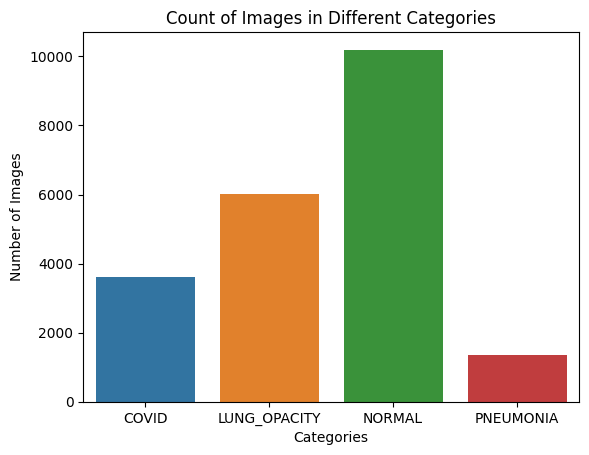

In [23]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))

plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Count of Images in Different Categories")
plt.show()

# Data Augmentation

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path="tmp/X-RAY/"

In [25]:
train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,validation_split=0.2)

In [26]:
train=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='training',class_mode='categorical')# input pixels of images trained for VGGnet
test=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='validation',class_mode='categorical')

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


# Model Definition

In [27]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
eff = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

In [28]:
for layer in eff.layers:
    layer.trainable =  False

In [35]:
eff_model = Sequential([
    eff,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

eff_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [36]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

# Model Training

In [39]:
epochs = 10  
batch_size  = 16
eff_history = eff_model.fit(train,
                              steps_per_epoch = 16933 // batch_size,
                              epochs = 10, 
                              validation_data = test,
                              callbacks=[EarlyStopping])

Epoch 1/10
1058/1058 [==============================] - 240s 227ms/step - loss: 1.2153 - accuracy: 0.4799 - val_loss: 1.1988 - val_accuracy: 0.4816
Epoch 2/10
1058/1058 [==============================] - 241s 227ms/step - loss: 1.2018 - accuracy: 0.4809 - val_loss: 1.1928 - val_accuracy: 0.4816
Epoch 3/10
1058/1058 [==============================] - 242s 228ms/step - loss: 1.1975 - accuracy: 0.4814 - val_loss: 1.1918 - val_accuracy: 0.4816
Epoch 4/10
1058/1058 [==============================] - 241s 227ms/step - loss: 1.1945 - accuracy: 0.4813 - val_loss: 1.1898 - val_accuracy: 0.4816
Epoch 5/10
1058/1058 [==============================] - 240s 227ms/step - loss: 1.1936 - accuracy: 0.4812 - val_loss: 1.1896 - val_accuracy: 0.4816
Epoch 6/10
1058/1058 [==============================] - 238s 225ms/step - loss: 1.1922 - accuracy: 0.4815 - val_loss: 1.1895 - val_accuracy: 0.4816
Epoch 7/10
1058/1058 [==============================] - 238s 225ms/step - loss: 1.1913 - accuracy: 0.4815 - val_

# Evaluation

In [40]:
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)  
test_generator = test_datagen.flow_from_directory(
    "tmp/X-RAY/",
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False,  # Ensure no shuffling for consistent evaluation
    subset='validation'   
)

Found 4232 images belonging to 4 classes.


In [41]:
y_pred = eff_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

67/67 [==============================] - 16s 202ms/step
Accuracy: 48.16%


In [43]:
class_names = ['COVID', 'LUNG_OPACITY','NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       COVID       0.00      0.00      0.00       723
LUNG_OPACITY       0.00      0.00      0.00      1202
      NORMAL       0.48      1.00      0.65      2038
   PNEUMONIA       0.00      0.00      0.00       269

    accuracy                           0.48      4232
   macro avg       0.12      0.25      0.16      4232
weighted avg       0.23      0.48      0.31      4232



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation Graphs

In [44]:
training_loss = eff_history.history['loss']
validation_loss = eff_history.history['val_loss']

training_accuracy = eff_history.history['accuracy']
validation_accuracy = eff_history.history['val_accuracy']

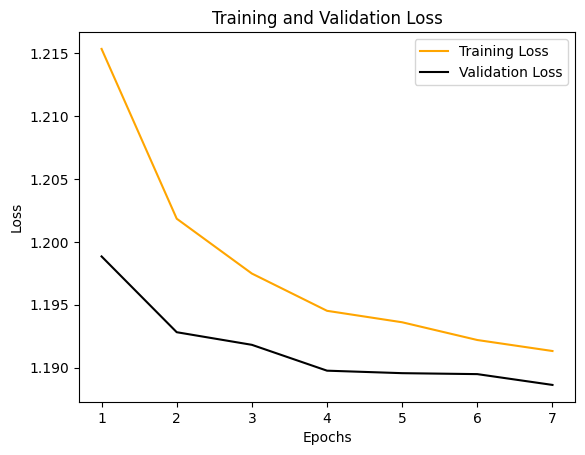

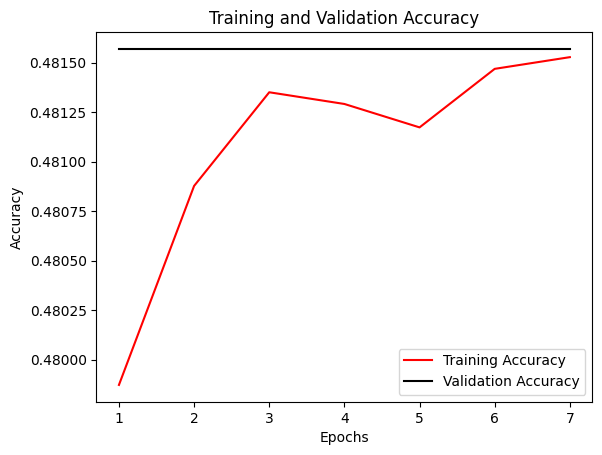

In [45]:
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'orange', label='Training Loss')
plt.plot(epochs, validation_loss, 'k', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, training_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'k', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
